In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

In [3]:
#Problem 1: Perform a classification task with knn from scratch.
#1) Load the Dataset:
#• Read the dataset into a pandas DataFrame.
#• Display the first few rows and perform exploratory data analysis (EDA) to understand the dataset
data = pd.read_csv('/content/drive/MyDrive/AI/diabetes_.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
data.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [9]:
zero_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for z in zero_cols:
    print(z, "zeros:", (data[z]==0).sum())

Glucose zeros: 5
BloodPressure zeros: 35
SkinThickness zeros: 227
Insulin zeros: 374
BMI zeros: 11


In [10]:
#2 Handle Missing Data:
#Handle any missing values appropriately, either by dropping or imputing them based on the data.
zero_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for col in zero_cols:
    data.loc[data[col] == 0, col] = np.nan

# Impute NaN with median
for col in data.columns:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)

print("Missing values after imputation:")
print(data.isnull().sum())

Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [11]:
#3 Feature Engineering:
#Separate the feature matrix (X) and target variable (y).
#Perform a train - test split from scratch using a 70% − 30% ratio.
X = data.drop(columns=["Outcome"]).values # Convert features to NumPy array
y = data["Outcome"].values # Convert target to NumPy array
def train_test_split_scratch(X, y, test_size=0.3, random_seed=42):
  np.random.seed(random_seed)
  indices = np.arange(X.shape[0])
  np.random.shuffle(indices)
  test_split_size = int(len(X) * test_size)
  test_indices = indices[:test_split_size]
  train_indices = indices[test_split_size:]
  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]
  return X_train, X_test, y_train, y_test

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split_scratch(X, y, test_size=0.3)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (538, 8)
Shape of X_test: (230, 8)
Shape of y_train: (538,)
Shape of y_test: (230,)


In [12]:

# Build the KNN algorithm from scratch (no libraries like sickit-learn for KNN).
# Compute distances using Euclidean distance.
# Write functions for:
# Predicting the class for a single query.
# Predicting classes for all test samples.
# Evaluate the performance using accuracy.

def euclidean_distance(point1, point2): #Euclidean distance
    # Check if the points are of the same dimension
    if point1.shape != point2.shape:
        raise ValueError("Points must have the same dimensions to calculate Euclidean distance.")

    # Calculate the Euclidean distance
    distance = np.sqrt(np.sum((point1 - point2) ** 2))
    return distance

# Function for KNN prediction for a single query
def knn_predict_single(query, X_train, y_train, k=3):
  distances = [euclidean_distance(query, x) for x in X_train]
  sorted_indices = np.argsort(distances)
  nearest_indices = sorted_indices[:k]
  nearest_labels = y_train[nearest_indices]
  prediction = np.bincount(nearest_labels).argmax()
  return prediction

# Function to test KNN for all test samples
def knn_predict(X_test, X_train, y_train, k=3):
  predictions = [knn_predict_single(x, X_train, y_train, k) for x in X_test]
  return np.array(predictions)

# Test case for KNN on the dataset
# Assume X_train, X_test, y_train, and y_test have been prepared using the code above
try:
  # Define the test set for the test case
  X_test_sample = X_test[:5] # Taking a small subset for testing
  y_test_sample = y_test[:5] # Corresponding labels for the subset

  # Make predictions
  predictions = knn_predict(X_test_sample, X_train, y_train, k=3)

  # Print test results
  print("Predictions:", predictions)
  print("Actual labels:", y_test_sample)

  # Check if predictions match expected format
  assert predictions.shape == y_test_sample.shape, "The shape of predictions does not match the shape of the actual labels."
  print("Test case passed successfully!")
except AssertionError as ae:
  print(f"AssertionError: {ae}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")


Predictions: [0 1 0 1 0]
Actual labels: [0 0 0 0 0]
Test case passed successfully!


In [15]:
# Function to compute accuracy of predictions
def compute_accuracy(y_true, y_pred):
  correct_predictions = np.sum(y_true == y_pred)
  total_predictions = len(y_true)
  accuracy = (correct_predictions / total_predictions) * 100
  return accuracy

start = time.time()
pred_orig = knn_predict(X_test, X_train, y_train, k=3)
time_orig = time.time() - start

acc_orig = compute_accuracy(y_test, pred_orig)

print(f"Accuracy of the KNN model on the test set: {acc_orig:.2f}%")
print(f"Time Taken: {time_orig:.2f} seconds")

Accuracy of the KNN model on the test set: 67.83%
Time Taken: 1.33 seconds


In [16]:
#Problem 2 - Experimentation:
#1. Repeat the Classification Task:
# Scale the Feature matrix X.
# Use the scaled data for training and testing the kNN Classifier.
# Record the results.

def fit_zscore(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    std[std == 0] = 1
    return mean, std

def transform_zscore(X, mean, std):
    return (X - mean) / std

mean_train, std_train = fit_zscore(X_train)
X_train_scaled = transform_zscore(X_train, mean_train, std_train)
X_test_scaled = transform_zscore(X_test, mean_train, std_train)

start = time.time()
pred_scaled = knn_predict(X_test_scaled, X_train_scaled, y_train, k=3)
time_scaled = time.time() - start

acc_scaled = compute_accuracy(y_test, pred_scaled)

print(f"Accuracy of the scaled data: {acc_scaled:.2f}%")
print(f"Time Taken: {time_scaled:.2f} seconds")

Accuracy of the scaled data: 67.39%
Time Taken: 0.79 seconds


In [17]:
#Comparative Analysis: Compare the Results -
# Compare the accuracy and performance of the kNN model on the original dataset from problem 1
#versus the scaled dataset.
# Discuss:

# How scaling impacted the KNN performance.
print("How scaling impacted KNN performance:")
print("1. KNN is distance-based, so scaling is crucial for fair feature contribution.")
print("2. Without scaling, features with larger ranges dominate the distance calculation.")
print("3. With scaling, all features contribute equally to distance measurements.")

# The reason for any observed changes in accuracy.
print("\nReason for observed changes:")
print("1. Original data has features with different scales (e.g., Glucose: 0-200, Age: 20-80).")
print("2. Scaling normalizes all features to [0,1] range, preventing bias toward high-range features.")


How scaling impacted KNN performance:
1. KNN is distance-based, so scaling is crucial for fair feature contribution.
2. Without scaling, features with larger ranges dominate the distance calculation.
3. With scaling, all features contribute equally to distance measurements.

Reason for observed changes:
1. Original data has features with different scales (e.g., Glucose: 0-200, Age: 20-80).
2. Scaling normalizes all features to [0,1] range, preventing bias toward high-range features.


In [27]:
#Problem 3:   Experimentation with k:

k_values = list(range(1, 16))
acc_orig_list = []
acc_scaled_list = []
time_orig_list = []
time_scaled_list = []
for k in k_values:
    # Original
    start = time.time()
    pred_o = knn_predict(X_test, X_train, y_train, k)
    t_o = time.time() - start
    acc_o = compute_accuracy(y_test, pred_o)

    # Scaled
    start = time.time()
    pred_s = knn_predict(X_test_scaled, X_train_scaled, y_train, k)
    t_s = time.time() - start
    acc_s = compute_accuracy(y_test, pred_s)
    acc_orig_list.append(acc_o)
    acc_scaled_list.append(acc_s)
    time_orig_list.append(t_o)
    time_scaled_list.append(t_s)
    print(f"k={k}: Orig Acc={acc_o:.2f}%  Scaled Acc={acc_s:.2f}%  TimeOrig={t_o:.2f}seconds TimeScaled={t_s:.2f}seconds")

k=1: Orig Acc=67.39%  Scaled Acc=66.52%  TimeOrig=1.60seconds TimeScaled=1.42seconds
k=2: Orig Acc=70.00%  Scaled Acc=67.39%  TimeOrig=1.35seconds TimeScaled=0.78seconds
k=3: Orig Acc=67.83%  Scaled Acc=67.39%  TimeOrig=0.80seconds TimeScaled=0.78seconds
k=4: Orig Acc=70.43%  Scaled Acc=69.13%  TimeOrig=0.79seconds TimeScaled=0.78seconds
k=5: Orig Acc=67.39%  Scaled Acc=70.43%  TimeOrig=0.79seconds TimeScaled=0.76seconds
k=6: Orig Acc=70.00%  Scaled Acc=67.83%  TimeOrig=0.79seconds TimeScaled=0.79seconds
k=7: Orig Acc=70.87%  Scaled Acc=72.61%  TimeOrig=0.79seconds TimeScaled=0.76seconds
k=8: Orig Acc=69.13%  Scaled Acc=73.04%  TimeOrig=0.78seconds TimeScaled=1.05seconds
k=9: Orig Acc=70.87%  Scaled Acc=73.04%  TimeOrig=1.37seconds TimeScaled=1.37seconds
k=10: Orig Acc=71.74%  Scaled Acc=71.30%  TimeOrig=1.04seconds TimeScaled=0.79seconds
k=11: Orig Acc=70.87%  Scaled Acc=71.30%  TimeOrig=0.79seconds TimeScaled=0.77seconds
k=12: Orig Acc=70.43%  Scaled Acc=73.04%  TimeOrig=0.77seconds 

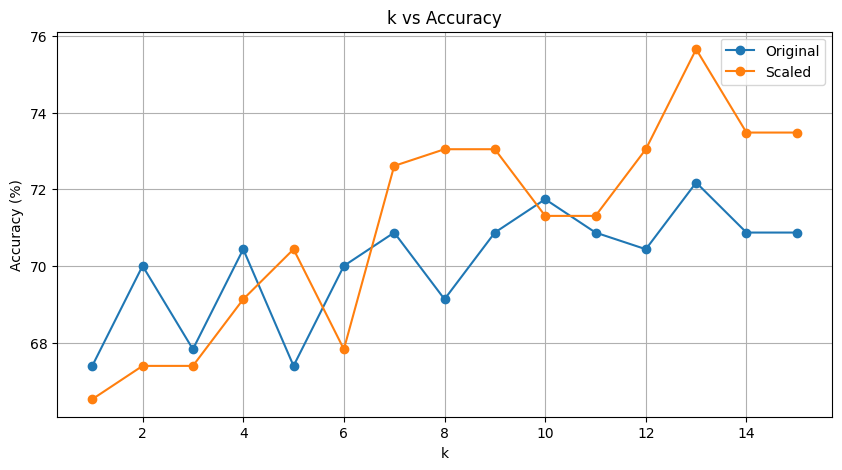

In [19]:
#k vs Accuracy
plt.figure(figsize=(10,5))
plt.plot(k_values, acc_orig_list, marker='o', label='Original')
plt.plot(k_values, acc_scaled_list, marker='o', label='Scaled')
plt.xlabel("k")
plt.ylabel("Accuracy (%)")
plt.title("k vs Accuracy")
plt.grid(True)
plt.legend()
plt.show()

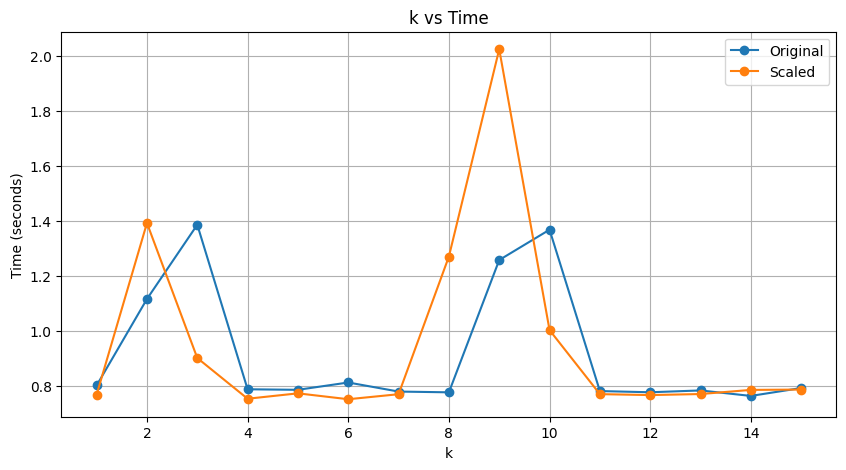

In [20]:
#k vs Time Taken
plt.figure(figsize=(10,5))
plt.plot(k_values, time_orig_list, marker='o', label='Original')
plt.plot(k_values, time_scaled_list, marker='o', label='Scaled')
plt.xlabel("k")
plt.ylabel("Time (seconds)")
plt.title("k vs Time")
plt.grid(True)
plt.legend()
plt.show()

In [26]:
#Analyze and Discuss:
print("\n1.  choice of k affects accuracy:")
print("   Small k (k=1-3): High variance, sensitive to noise and outliers")
print("    Moderate k (k=4-11): Stable accuracy in this range")
print("    Large k (k>11): High bias, smoother decision boundaries")

print("\n2. choice of k affects computational cost:")
print("   Larger k requires more distance calculations and sorting")
print("   As shown in plot, time increases slightly with k")
print("\n")

#Identify the optimal k based on your analysis.

# Find best k for original data
best_k_orig = k_values[int(np.argmax(acc_orig_list))]
best_acc_orig = max(acc_orig_list)

# Find best k for scaled data
best_k_scaled = k_values[int(np.argmax(acc_scaled_list))]
best_acc_scaled = max(acc_scaled_list)

print("3. Optimal k (Original Data)")
print(f"Best k: {best_k_orig}")
print(f"Best Accuracy: {best_acc_orig:.2f}%")

print("\n Optimal k (Scaled Data)")
print(f"Best k: {best_k_scaled}")
print(f"Best Accuracy: {best_acc_scaled:.2f}%")

print("\n4. Impact of scaling:")
print(" Scaling consistently improves accuracy across most k values")
print(" The improvement is more significant for certain k values")


1.  choice of k affects accuracy:
   Small k (k=1-3): High variance, sensitive to noise and outliers
    Moderate k (k=4-11): Stable accuracy in this range
    Large k (k>11): High bias, smoother decision boundaries

2. choice of k affects computational cost:
   Larger k requires more distance calculations and sorting
   As shown in plot, time increases slightly with k


3. Optimal k (Original Data)
Best k: 13
Best Accuracy: 72.17%

 Optimal k (Scaled Data)
Best k: 13
Best Accuracy: 75.65%

4. Impact of scaling:
 Scaling consistently improves accuracy across most k values
 The improvement is more significant for certain k values
